In [1]:
import os

if not os.path.exists('CIFAR10_data'):
    
    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !mkdir CIFAR10_data
    !tar -xf cifar-10-python.tar.gz -C CIFAR10_data

if not os.path.exists('CIFAR10_mask'):
    
    !tar -xf CIFAR10_mask.tar

from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import cv2

from models import CIFAR_CNN
from utils import unpickle

datadir = 'CIFAR10_data/cifar-10-batches-py/'
batches_train = sorted([datadir + batch for batch in os.listdir(datadir) if 'data_batch' in batch], key=lambda x: int(x[-1]))
batch_test = datadir + 'test_batch'

logdir = 'tf_logs/standard/'

In [2]:
def load_images(img_dir, img_size=(32,32)):
    
    def file_number(x):
        
        return int(x.split('.')[0].split('_')[1])
    
    filenames = os.listdir(img_dir)
    
    image_files = {}
    mask_files = {}
    
    images = {}
    masks = {}
    
    for file in filenames:
        
        cls = file.split('_')[0]
        is_mask = 'mask' in file
        
        if is_mask:
            
            if cls in mask_files:
                mask_files[cls].append(file)
            else:
                mask_files[cls] = [file]
                
            mask_files[cls] = sorted(mask_files[cls], key=file_number)
        
        else:
            
            if cls in image_files:
                image_files[cls].append(file)
            else:
                image_files[cls] = [file]
            
            image_files[cls] = sorted(image_files[cls], key=file_number)
    
    for k, v in image_files.items():
        
        res = []
        
        for file in v:
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS)).reshape(1,32,32,-1)
            res.append(image)
        
        res = np.concatenate(res, axis=0)[...,::-1]
        res = res / 127.5 - 1.0
        images[k] = res
    
    for k, v in mask_files.items():
        
        res = []
        
        for file in v:
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS)).reshape(1,32,32,-1)
            res.append(image)
        
        res = np.concatenate(res, axis=0)
        masks[k] = res
    
    return images, masks

label_map = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}
class_map = {v.lower(): k for k, v in label_map.items()}

### Load Images and Masks

In [3]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(logdir + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

X = tf.get_collection('tensors')[0]
logits = tf.get_collection('tensors')[1]
yv = tf.reduce_max(logits, 1)
yi = tf.argmax(logits, 1)

images, masks = load_images('CIFAR10_mask/')

for k, v in images.items():
    predictions = sess.run(yi, feed_dict={X:v})
    correct_inds = np.where(predictions == class_map[k])
    images[k] = images[k][correct_inds]
    masks[k] = masks[k][correct_inds]

xs = np.concatenate([v[:10] for k, v in sorted(images.items())])
ms = np.concatenate([v[:10] < 200 for k, v in sorted(masks.items())])

sess.close()

INFO:tensorflow:Restoring parameters from tf_logs/standard/model


### Restore CNN

In [4]:
# Layer to perform feature map occlusion on
layer = 0

layers = []
layers.append('CNN/conv1/Relu')
layers.append('CNN/conv2/Relu')
layers.append('CNN/conv3/Relu')
layers.append('CNN/conv4/Relu')
layers.append('CNN/dense5/Relu')
layers.append('CNN/dense6/BiasAdd')

if layer < 2:
    shape = [None,32,32,32]
else:
    shape = [None,16,16,64]

tf.reset_default_graph()

sess = tf.InteractiveSession()
graph = tf.get_default_graph()

inp = tf.placeholder(tf.float32, shape=shape, name='input')
    
new_saver = tf.train.import_meta_graph(logdir + 'model.meta', input_map={layers[layer] + ':0':inp})
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

X = tf.get_collection('tensors')[0]
logits = tf.get_collection('tensors')[1]
yv = tf.reduce_max(logits, 1)
yi = tf.argmax(logits, 1)

ops = [tf.get_default_graph().get_operation_by_name(name) for name in layers]

INFO:tensorflow:Restoring parameters from tf_logs/standard/model


### Feature Map Occlusion

100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


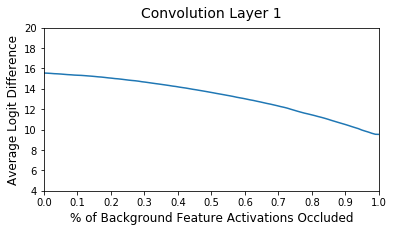

In [5]:
ress = []

for ind in tqdm(range(100)):

    image = xs[ind].reshape(1,32,32,3)
    label = ind // 10

    mask_large = ms[ind].reshape(1,32,32,1)
    mask_small = cv2.resize(ms[ind].reshape(32,32).astype(np.uint8), dsize=(16,16), interpolation=cv2.INTER_CUBIC)
    mask_small = mask_small.reshape(1,16,16,1).astype(np.bool)

    if layer < 2:
        mask1 = np.ones([1,32,32,32]) * mask_large
    else:
        mask1 = np.ones([1,16,16,64]) * mask_small

    mask1 = np.where(mask1 == 1, True, False)
    name = "Background Feature Activations"

    a = sess.run(ops[layer].outputs[0], feed_dict={X:image})

    percentiles = np.linspace(0, 100, 100)

    res = []

    # Take average over 50 random trials
    for _ in range(50):

        # Generate random ordering for feature occlusion
        order = np.arange(0, mask1.size, 1)
        np.random.shuffle(order)
        order = order.reshape(mask1.shape)
        order = order * mask1

        # Occlusion process
        mask2 = np.concatenate([np.where(order < np.percentile(order[(order != 0)], p), True, False) for p in percentiles])

        mask = np.bitwise_and(mask1, mask2)
        mask = np.bitwise_not(mask)

        a_occluded = a * mask
        l_occluded = sess.run(logits, feed_dict={inp:a_occluded})
        l_occluded = np.transpose(l_occluded)

        res.append(l_occluded)

    res = np.array(res)
    res = np.mean(res, axis=0, keepdims=True)
    ress.append(res)

ress = np.concatenate(ress)

sess.close()

# Plotting
i = np.linspace(0, 99, 100, dtype=np.int32).reshape(100)
j = np.tile(np.linspace(0, 9, 10, dtype=np.int32).reshape(10,1), [1,10]).reshape(100)

orig_cls = ress[i,j]

temp = np.copy(ress)
temp[i,j] = -np.infty
next_cls = np.max(temp, axis=1)

delta = orig_cls - next_cls
delta_mean = np.mean(delta, axis=0)
delta_errs = np.std(delta, axis=0)

plt.figure(figsize=(6,3))
plt.plot(percentiles / 100, delta_mean)
plt.title('Convolution Layer {}'.format(layer + 1), fontsize=14, pad=10)
plt.xlabel('% of {} Occluded'.format(name), fontsize=12)
plt.ylabel('Average Logit Difference', fontsize=12)
plt.xticks(np.linspace(0, 1, 11))
plt.xlim([0,1])
plt.ylim([4,20])
plt.show()